In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
from pandas import Series
from pandas import read_csv
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import numpy as np
import keras
import matplotlib.pyplot as plt
import pandas as pd
import glob
from keras.layers import Dropout
from sklearn.utils import shuffle
import sys
from pandas import DataFrame
import math
from keras.optimizers import Adam
import tensorflow as tf
import os
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
import joblib

Using TensorFlow backend.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
os.chdir('/content/drive/My Drive/New LSTM Crack')

In [7]:
train_files = glob.glob('./Training/NonHeatTreated/*.csv')
print('Files in use: {}'.format(len(train_files)))
train_files.sort()
train_files = train_files[-6:] + train_files[:-6]
print(train_files)
train_df = pd.concat([pd.read_csv(f) for f in train_files])

Files in use: 64
['./Training/NonHeatTreated/2-15-1800N-150T_training.csv', './Training/NonHeatTreated/2-16-1600N-150T_training.csv', './Training/NonHeatTreated/2-16-1700N-150T_training.csv', './Training/NonHeatTreated/t100_8-12-18_R05_1600N_training.csv', './Training/NonHeatTreated/t101_8-12-18_R05_1800N_training.csv', './Training/NonHeatTreated/t99_8-12-18_R05_1700N_training.csv', './Training/NonHeatTreated/1600N_t100.csv', './Training/NonHeatTreated/1600N_t15.csv', './Training/NonHeatTreated/1600N_t20.csv', './Training/NonHeatTreated/1600N_t23.csv', './Training/NonHeatTreated/1600N_t30.csv', './Training/NonHeatTreated/1600N_t36.csv', './Training/NonHeatTreated/1600N_t46.csv', './Training/NonHeatTreated/1600N_t51.csv', './Training/NonHeatTreated/1600N_t55.csv', './Training/NonHeatTreated/1600N_t63.csv', './Training/NonHeatTreated/1600N_t64.csv', './Training/NonHeatTreated/1600N_t66.csv', './Training/NonHeatTreated/1600N_t71.csv', './Training/NonHeatTreated/1600N_t73.csv', './Training

In [8]:
# For use in Multivariate Predictions
crack_series = train_df.iloc[:,1].to_numpy().reshape((len(train_df),1))
crack_series = crack_series

In [9]:
force_series = train_df.iloc[:,2].to_numpy().reshape((len(train_df),1))
temp_series = train_df.iloc[:,3].to_numpy().reshape((len(train_df),1))/553

In [10]:
stress_intensity = []
specimen_width = 0.0408 #meters #40.8 mm
crossSectArea = 2.6388 #meters

for i in range(len(train_df)):
  term1 = (force_series[i] / crossSectArea) * sqrt(3.14 * crack_series[i])
  term2 = 8.574
  term3 = 10.365 * (crack_series[i] / specimen_width)
  term4 = 5.499 * ((crack_series[i] / specimen_width)**2)
  intensity = term1*(term2 - term3 + term4)
  stress_intensity.append(intensity)
  if i % 100000 == 0:
    print(i)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000


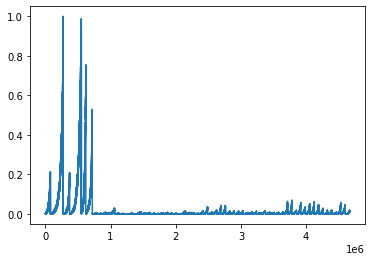

In [11]:
stress_intensity = np.asarray(stress_intensity).reshape(len(train_df),1)
Scaler = MinMaxScaler()
Scaler.fit(stress_intensity)
joblib.dump(Scaler, './Weights/Scaler_NHT2.save')
stress_intensity = Scaler.transform(stress_intensity)
plt.plot(stress_intensity)

In [12]:
#series= np.hstack((crack_change, temp_series, stress_intensity))
series= np.hstack((crack_series, temp_series, stress_intensity))
print(series)

[[1.77828598e-01 7.65189873e-01 5.83039191e-04]
 [2.70716375e-01 7.65189873e-01 1.92835877e-03]
 [2.25687100e-01 7.65189873e-01 1.15666185e-03]
 ...
 [5.81883310e-01 5.42495479e-01 1.52202619e-02]
 [5.61604432e-01 5.42495479e-01 1.38616775e-02]
 [5.64596467e-01 5.42495479e-01 1.40573392e-02]]


In [13]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, 1:], sequences[end_ix, 0]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [14]:
train_size = int(len(series) * 0.80)
test_size = len(series) - train_size
train, test = series[0:train_size], series[train_size:len(series)]

In [15]:
# choose a number of time steps
n_steps = 7
# split into samples
X_train, y_train = split_sequences(train, n_steps)
X_test, y_test = split_sequences(test, n_steps)


In [16]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 2 # temp stress force

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [17]:
print(X_train)

[[[7.65189873e-01 5.83039191e-04]
  [7.65189873e-01 1.92835877e-03]
  [7.65189873e-01 1.15666185e-03]
  ...
  [7.65189873e-01 1.65019178e-03]
  [7.65189873e-01 9.62449674e-04]
  [7.65189873e-01 3.73898772e-04]]

 [[7.65189873e-01 1.92835877e-03]
  [7.65189873e-01 1.15666185e-03]
  [7.65189873e-01 1.11213542e-03]
  ...
  [7.65189873e-01 9.62449674e-04]
  [7.65189873e-01 3.73898772e-04]
  [7.65189873e-01 5.78137512e-04]]

 [[7.65189873e-01 1.15666185e-03]
  [7.65189873e-01 1.11213542e-03]
  [7.65189873e-01 1.65019178e-03]
  ...
  [7.65189873e-01 3.73898772e-04]
  [7.65189873e-01 5.78137512e-04]
  [7.65189873e-01 1.67463621e-03]]

 ...

 [[5.42495479e-01 6.32103551e-04]
  [5.42495479e-01 5.33297315e-04]
  [5.42495479e-01 7.12160113e-04]
  ...
  [5.42495479e-01 4.58165508e-04]
  [5.42495479e-01 6.61022077e-04]
  [5.42495479e-01 5.46607731e-04]]

 [[5.42495479e-01 5.33297315e-04]
  [5.42495479e-01 7.12160113e-04]
  [5.42495479e-01 6.18709023e-04]
  ...
  [5.42495479e-01 6.61022077e-04]
  [5

In [ ]:
print(X_train.shape)

(3733997, 7, 2)


In [ ]:
opt = Adam(learning_rate = 0.0005)
# define model
model = Sequential()
model.add(Bidirectional(LSTM(1000, activation='relu',return_sequences = True, dropout=0.4), input_shape=(n_steps, n_features)))
model.add(Dense(500))
model.add(Bidirectional(LSTM(1000, activation='relu')))
model.add(Dense(1))
model.compile(optimizer=opt, loss='mse')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
# fit model
model.fit(X_train, y_train, epochs=10, verbose=1, batch_size = 500)


Epoch 1/10
3733997/3733997 [==============================] - 827s 222us/step - loss: 0.0278
Epoch 2/10
3733997/3733997 [==============================] - 823s 220us/step - loss: 0.0240
Epoch 3/10
3733997/3733997 [==============================] - 823s 220us/step - loss: 0.0233
Epoch 4/10
3733997/3733997 [==============================] - 823s 220us/step - loss: 0.0229
Epoch 5/10
3733997/3733997 [==============================] - 824s 221us/step - loss: 0.0227
Epoch 6/10
3733997/3733997 [==============================] - 823s 220us/step - loss: 0.0224
Epoch 7/10
3733997/3733997 [==============================] - 821s 220us/step - loss: 0.0221
Epoch 8/10
3733997/3733997 [==============================] - 821s 220us/step - loss: 0.0218
Epoch 9/10
3733997/3733997 [==============================] - 821s 220us/step - loss: 0.0216
Epoch 10/10
3733997/3733997 [==============================] - 823s 221us/step - loss: 0.0213


In [ ]:
yhat = model.predict(X_test, verbose=1)

933494/933494 [==============================] - 299s 320us/step


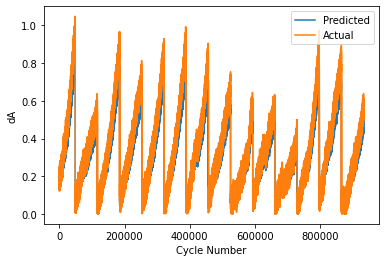

In [ ]:
plt.figure()
plt.plot(yhat, label="Predicted")
plt.plot(y_test, label="Actual")
plt.xlabel("Cycle Number")
plt.ylabel("dA")
plt.legend()
plt.show()


In [ ]:
mae =  mean_absolute_error(y_test,yhat)
print(mae)

0.05641103112907088


In [ ]:
model.save("./Weights/Model_NHT2")